#          ***Skin Cancer Classification (HAM10000)***

---



---



## *Import Libraries*

In [ ]:
import os
from keras.models import model_from_json
import matplotlib.pyplot as plt
import numpy as np
from google.colab.patches import cv2_imshow
import pandas as pd
import cv2 as cv
import random
import matplotlib.image as mpimg
from google.colab import drive
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, regularizers
from keras.models import model_from_json
from google.colab.patches import cv2_imshow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from matplotlib import pyplot
import sys
import re
import seaborn as sns
from google.colab import drive

## *Define necassary functions*

In [ ]:
def rescale_image(image,w=256,h=256):

  """
A function that rescale a given image with a given width and hieght,
w & h are set to 256 by default => reulting a (256,256,3) image in our case



*Args :
image : Numpy array of the image
w : width of the image (int)
h: height of the image (int)

*return :

Numpy array of shape (w,h,3)


  """

  width_scale = w/image.shape[1]
  height_scale = h/image.shape[0]

  width = int(image.shape[1] * width_scale)
  height = int(image.shape[0] * height_scale)

  dim = (width, height) # resize image ( down scale or up scale )
  resized = cv.resize(image , dim, interpolation = cv.INTER_AREA)
  return resized


def transform_to_images(dataframe):
    """
    Transforms each row ofthe DataFrame into a 28x28x3 image.

    *param dataframe: Pandas DataFrame where each row represents a flattened image.
    *return: A list of NumPy arrays, each array representing an image.
    """
    images = []
    for _, row in dataframe.iterrows():
        # Assuming the last column might be labels or non-image data; exclude it if present
        if len(row) == 2353:
            image_data = row[:-1]
        else:
            image_data = row

        # Reshape the row into a 28x28x3 array
        image = np.array(image_data, dtype=np.uint8).reshape((28, 28, 3))
        images.append(image)

    return images




# reference: https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000/discussion/183083
classes={'akiec': ('Actinic Keratoses and Intraepithelial Carcinomae',0),
         'bcc' : ('Basal Cell carcinoma',1),
         'bkl': ('Benign Keratosis-like lesions',2),
         'df': ('Dermatofibroma',3),
         'nv': (' Melanocytic Nevi',4),
         'vasc': (' Pyogenic Granulomas and Hemorrhage',5),
         'mel': ('Melanoma',6)}





def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(classes[target_class][0])
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img






def summarize_diagnostics(history):


  """
  Function that plots loss & accuracy curves of training and validation set

  Args :
  history : history of a model

  Return :
  plots

  """
  plt.figure(figsize=(12,10))
  plt.subplot(211)
  plt.title('Cross Entropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='test')

	# plot accuracy
  plt.subplot(212)
  plt.title('Classification Accuracy')
  plt.plot(history.history['accuracy'], color='blue', label='train')
  plt.plot(history.history['val_accuracy'], color='orange', label='test')
  plt.subplots_adjust(bottom=0.5, right=0.8, top=0.9, wspace=0.9, hspace=0.9)
	# save plot to file
	#timestr = time.strftime("%Y%m%d-%H%M%S")
  plt.show()
  plt.close()



def save_model(model,modelfile_name):
  # serialize model to JSON
    model_json = model.to_json()
    with open(modelfile_name, "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(modelfile_name+".h5")
    print("Saved model to disk")


def load_model(model_name):
  # load json and create model
  json_file = open(model_name, 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  loaded_model = model_from_json(loaded_model_json)
  # load weights into new model
  loaded_model.load_weights(model_name+".h5")
  print("Loaded model from disk")






## ***Analysis of the meta data***

In [ ]:

path_meta_data='/content/drive/MyDrive/Portfolio/Skin Cancer Classification, Ham10000/HAM10000_metadata.csv'


df=pd.read_csv(path_meta_data)
df.head()






Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern


In [ ]:
df.shape

(10015, 8)

In [ ]:
df.info()
# Age has some missing values !!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
 7   dataset       10015 non-null  object 
dtypes: float64(1), object(7)
memory usage: 626.1+ KB


In [ ]:
df['dx'].unique() # unique labels in the dataset

array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object)

## ***Exploratory data analysis of the metadata***

### *Gender*

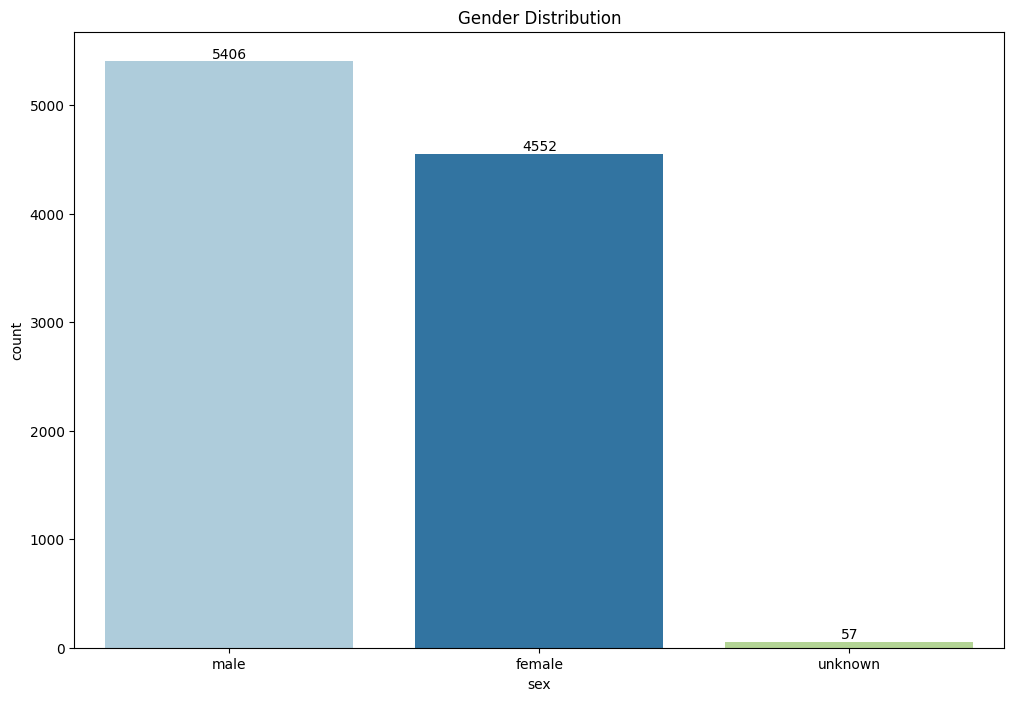

In [ ]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(12, 8))  # set the size of the figure
# Create a countplot <=> a bar plot to show the count of observations in each categorical bin using bars.
sns_countplot = sns.countplot(x='sex', data=df, palette='Paired')

# Label the bars in the countplot
for container in sns_countplot.containers:
    sns_countplot.bar_label(container)

# Set the title of the plot
plt.title('Gender Distribution')
plt.show()

### *Diagnosis*

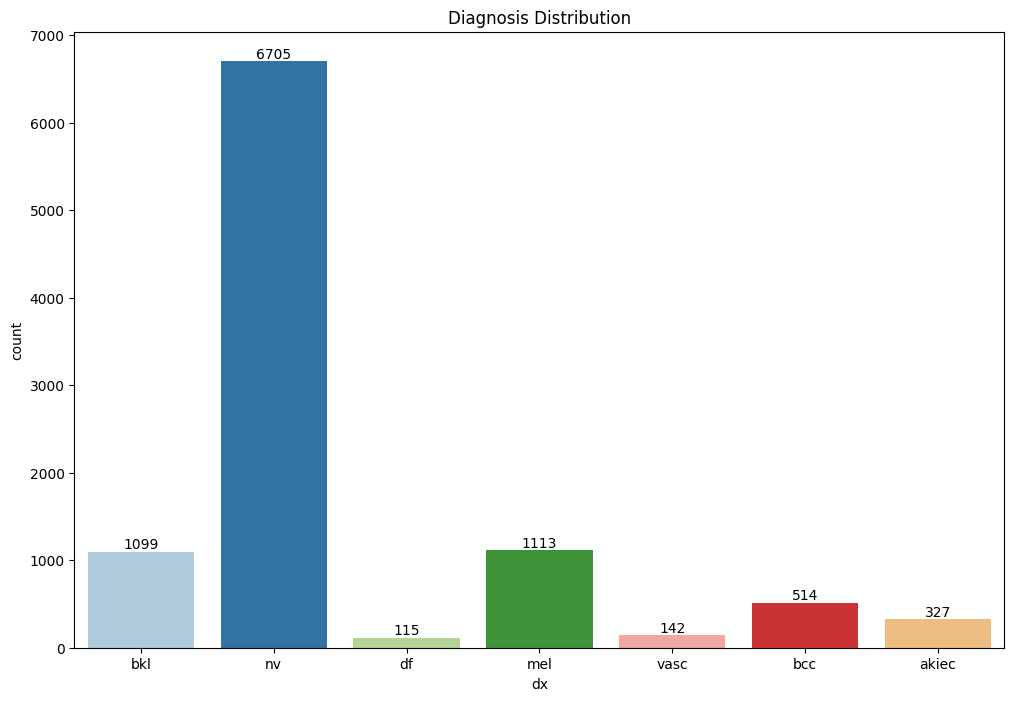

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))  # set the size of the figure
# Create a countplot <=> a bar plot to show the count of observations in each categorical bin using bars.
sns_countplot = sns.countplot(x='dx', data=df, palette='Paired')

# Label the bars in the countplot
for container in sns_countplot.containers:
    sns_countplot.bar_label(container)

# Set the title of the plot
plt.title('Diagnosis Distribution')
plt.show()

### *Localization*

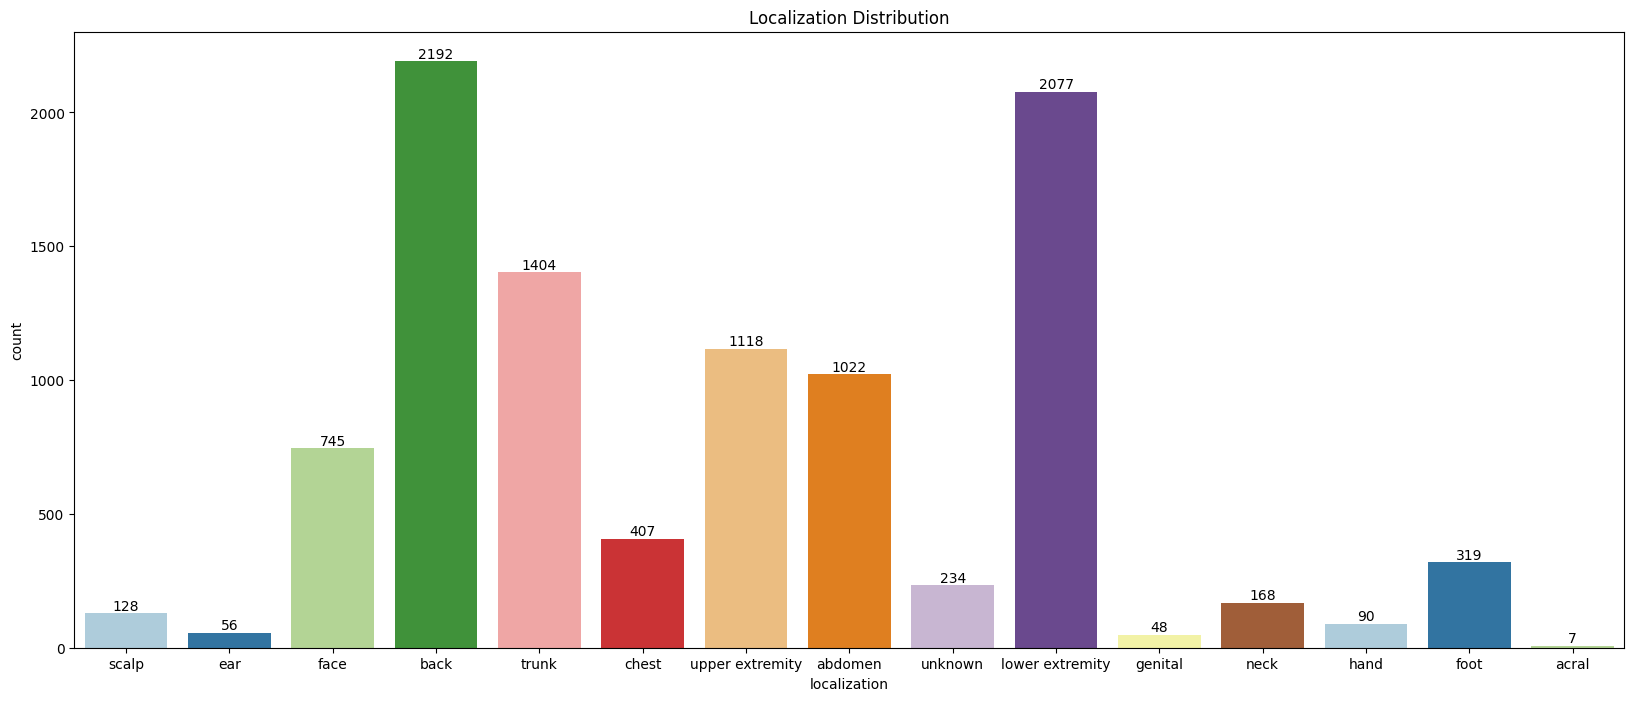

In [ ]:
fig, ax = plt.subplots(figsize=(20, 8))  # set the size of the figure
# Create a countplot <=> a bar plot to show the count of observations in each categorical bin using bars.
sns_countplot = sns.countplot(x='localization', data=df, palette='Paired')

# Label the bars in the countplot
for container in sns_countplot.containers:
    sns_countplot.bar_label(container)

# Set the title of the plot
plt.title('Localization Distribution')
plt.show()

### *Type*

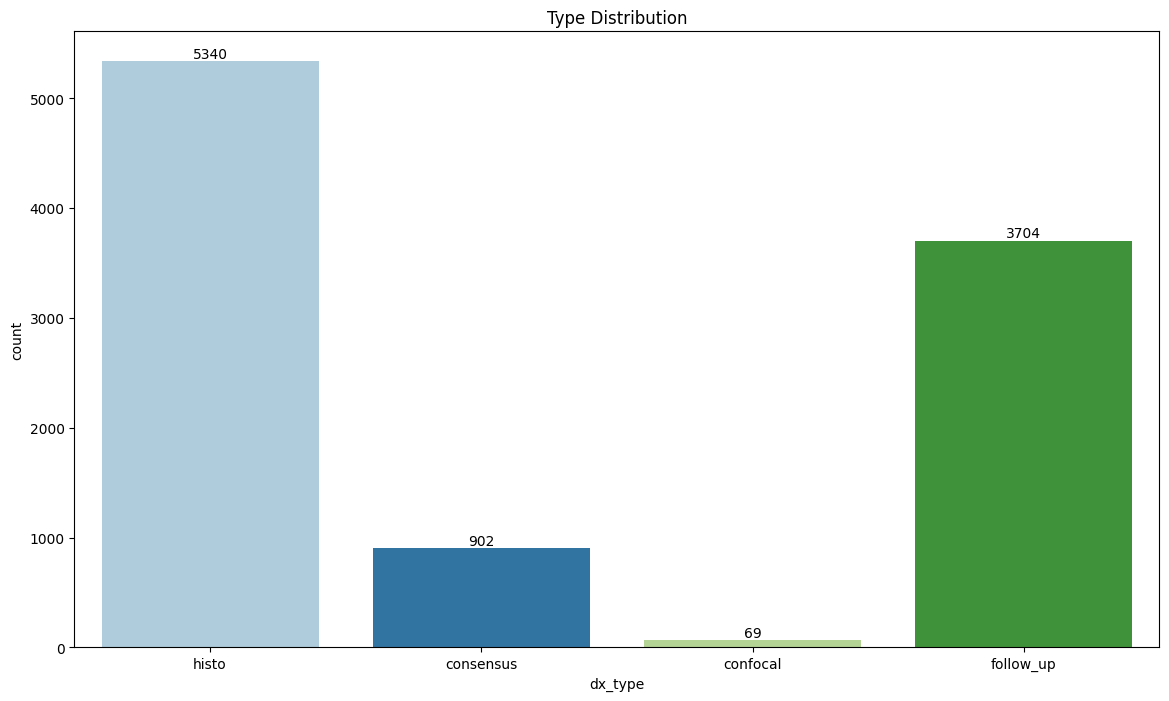

In [ ]:
fig, ax = plt.subplots(figsize=(14, 8))  # set the size of the figure
# Create a countplot <=> a bar plot to show the count of observations in each categorical bin using bars.
sns_countplot = sns.countplot(x='dx_type', data=df, palette='Paired')

# Label the bars in the countplot
for container in sns_countplot.containers:
    sns_countplot.bar_label(container)

# Set the title of the plot
plt.title('Type Distribution')
plt.show()

### *Data Sources*

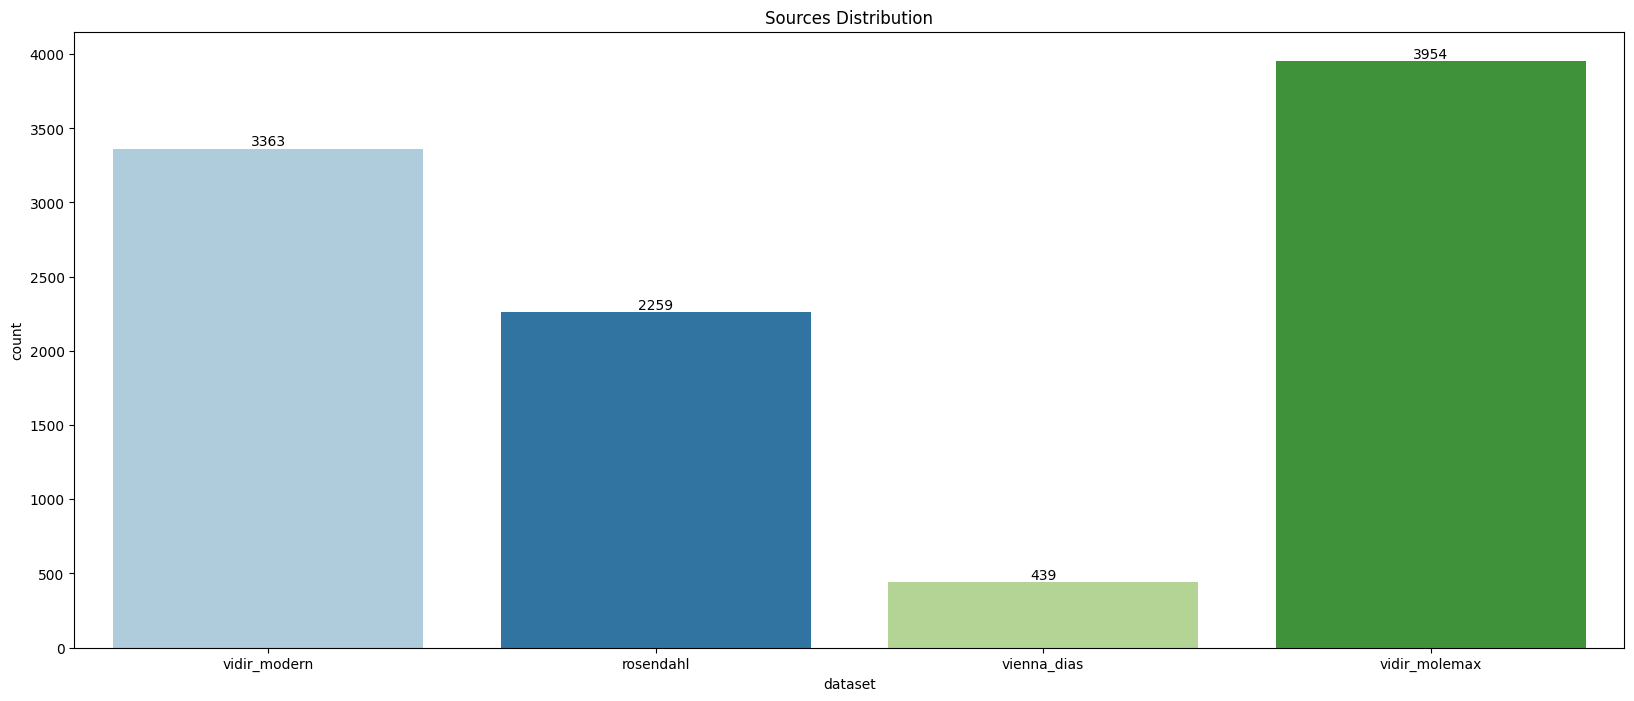

In [ ]:
fig, ax = plt.subplots(figsize=(20, 8))  # set the size of the figure
# Create a countplot <=> a bar plot to show the count of observations in each categorical bin using bars.
sns_countplot = sns.countplot(x='dataset', data=df, palette='Paired')

# Label the bars in the countplot
for container in sns_countplot.containers:
    sns_countplot.bar_label(container)

# Set the title of the plot
plt.title('Sources Distribution')
plt.show()

### *Age*

In [ ]:

# Fill the missing values wtih the mean
df['age'].fillna((df['age'].mean()), inplace=True)

Text(0.5, 1.0, 'Age Distribution with Density')

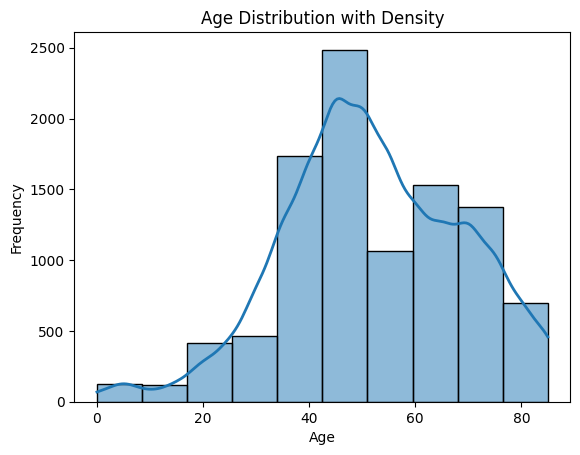

In [ ]:
sns.histplot(df['age'], kde=True, bins=10, line_kws={'linewidth': 2})
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution with Density')

## *Upload the images*

In [ ]:

# Walk through pizza_steak directory and list number of files
for dirpath, dirnames, filenames in os.walk("/content/drive/MyDrive/Portfolio/Skin Cancer Classification, Ham10000/dir_images"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '/content/drive/MyDrive/Portfolio/Skin Cancer Classification, Ham10000/dir_images'.
There are 7 directories and 0 images in '/content/drive/MyDrive/Portfolio/Skin Cancer Classification, Ham10000/dir_images/training'.
There are 0 directories and 5364 images in '/content/drive/MyDrive/Portfolio/Skin Cancer Classification, Ham10000/dir_images/training/nv'.
There are 0 directories and 262 images in '/content/drive/MyDrive/Portfolio/Skin Cancer Classification, Ham10000/dir_images/training/akiec'.
There are 0 directories and 879 images in '/content/drive/MyDrive/Portfolio/Skin Cancer Classification, Ham10000/dir_images/training/bkl'.
There are 0 directories and 411 images in '/content/drive/MyDrive/Portfolio/Skin Cancer Classification, Ham10000/dir_images/training/bcc'.
There are 0 directories and 890 images in '/content/drive/MyDrive/Portfolio/Skin Cancer Classification, Ham10000/dir_images/training/mel'.
There are 0 directories and 114 images in '/co

## ***View random Image in the dataset***

Image shape: (450, 600, 3)


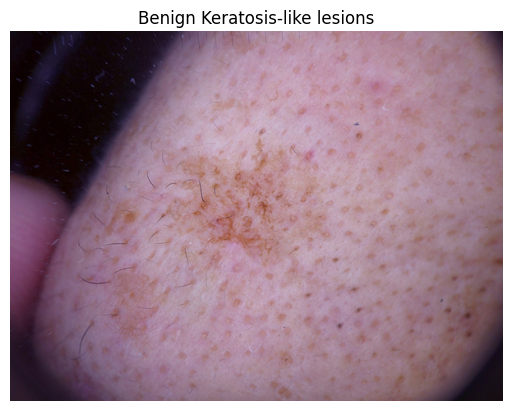

In [ ]:


dir_path="dir_images/training/"
# View a random image from the training dataset
img = view_random_image(target_dir=dir_path,
                        target_class="bkl")

In [ ]:
train_dir = "/content/drive/MyDrive/Portfolio/Skin Cancer Classification, Ham10000/dir_images/training/"
test_dir = "/content/drive/MyDrive/Portfolio/Skin Cancer Classification, Ham10000/dir_images/testining/"


## ***Data Augmentation***

In [ ]:

# Create ImageDataGenerator training instance with data augmentation
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # rotate the image slightly between 0 and 20 degrees (note: this is an int not a float)
                                             shear_range=0.2, # shear the image
                                             zoom_range=0.2, # zoom into the image
                                             width_shift_range=0.2, # shift the image width ways
                                             height_shift_range=0.2, # shift the image height ways
                                             horizontal_flip=True) # flip the image on the horizontal axis


test_datagen = ImageDataGenerator(rescale=1/255.)


In [ ]:

print("Augmented training images:")
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                   target_size=(224, 224),
                                                                   batch_size=32,
                                                                   class_mode='categorical',
                                                                   shuffle=True) # # Shuffle data

print(" testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(224, 224),
                                             batch_size=32,
                                             class_mode='categorical')

Augmented training images:
Found 8012 images belonging to 7 classes.
 testing images:
Found 2003 images belonging to 7 classes.


In [ ]:
#images, labels = train_data.next()
augmented_images, augmented_labels = train_data_augmented.next()

In [ ]:
#images, labels = train_data.next()
augmented_images.shape, augmented_labels.shape

((32, 224, 224, 3), (32, 7))

In [ ]:
#images, labels = train_data.next()
augmented_images.shape, augmented_labels.shape

((32, 224, 224, 3), (32, 7))

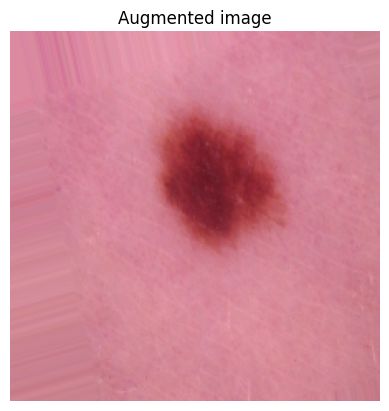

In [ ]:
random_number = random.randint(0, 31) # we're making batches of size 32, so we'll get a random instance
plt.imshow(augmented_images[random_number])
plt.title(f"Augmented image")
plt.axis(False);

## ***Training***

In [ ]:


model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', input_shape=(224, 224, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(1152, activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu',kernel_initializer='glorot_uniform'))
model.add(Dense(7, activation='softmax'))



# callback - Early Stopping to not overfit
EPOCHS=100
early_stopping = tf.keras.callbacks.EarlyStopping(
      monitor='val_loss',  #  metric to monitor
      patience=5,  # number of epochs to wait before stopping training when performance has stopped improving
      restore_best_weights=True  # restore model weights from the epoch with the best value of the monitored metric
      )
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            learning_rate=0.00001)



# Compile the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy','Precision','Recall'])

# Fit the model
history = model.fit(train_data_augmented, #  the augmented data is shuffled
                        epochs=25,
                        steps_per_epoch=len(train_data_augmented),
                        validation_data=test_data,
                        validation_steps=len(test_data),callbacks=[learning_rate_reduction,early_stopping])



Epoch 1/25
251/251 [==============================] - 2366s 9s/step - loss: 1.0944 - accuracy: 0.6249 - precision: 0.7645 - recall: 0.5049 - val_loss: 1.6722 - val_accuracy: 0.3125 - val_precision: 0.8356 - val_recall: 0.0609 - lr: 0.0010
Epoch 2/25
251/251 [==============================] - 214s 854ms/step - loss: 0.9035 - accuracy: 0.6692 - precision: 0.7928 - recall: 0.5550 - val_loss: 0.8780 - val_accuracy: 0.6945 - val_precision: 0.7978 - val_recall: 0.6206 - lr: 0.0010
Epoch 3/25
251/251 [==============================] - 214s 851ms/step - loss: 0.8651 - accuracy: 0.6833 - precision: 0.8071 - recall: 0.5796 - val_loss: 0.8207 - val_accuracy: 0.7074 - val_precision: 0.7909 - val_recall: 0.6365 - lr: 0.0010
Epoch 4/25
251/251 [==============================] - 205s 815ms/step - loss: 0.8297 - accuracy: 0.6926 - precision: 0.8163 - recall: 0.5929 - val_loss: 1.2994 - val_accuracy: 0.4528 - val_precision: 0.7430 - val_recall: 0.3335 - lr: 0.0010
Epoch 5/25
251/251 [==================

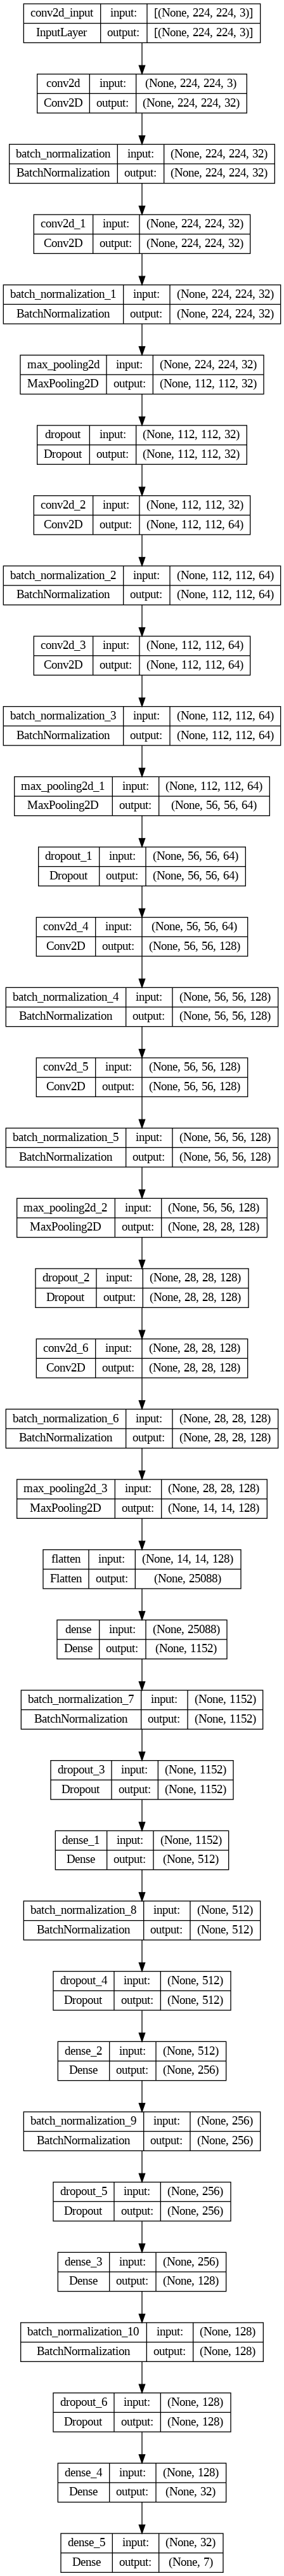

In [ ]:
# plot model summary

tf.keras.utils.plot_model(model , show_shapes=True)

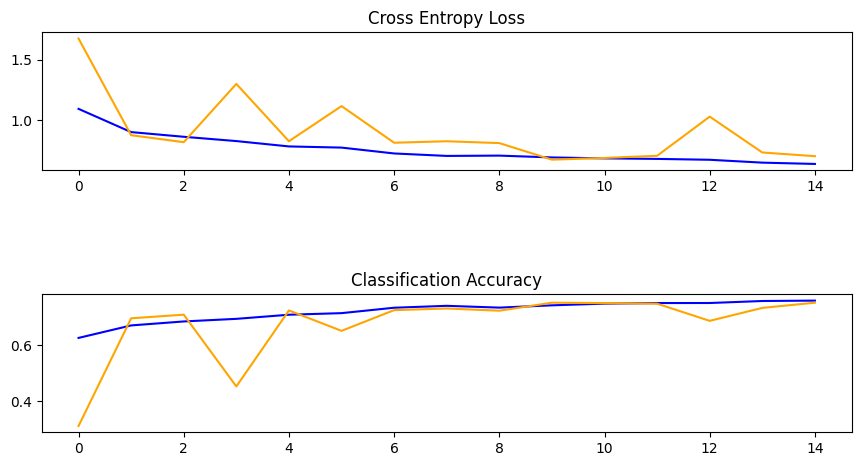

In [ ]:


summarize_diagnostics(history)


#classification report



In [ ]:
print('----------- Testing report ------------')
print(f" Testing Loss (Categorical Cross Entropy) :\t  {round(history.history['val_loss'][-1],3)} ")
print(f" Testing Accuracy :\t\t\t\t  {round(history.history['val_accuracy'][-1],3)*100} %")
print(f" Testing Precision :\t\t\t\t {round(history.history['val_precision'][-1],3)*100} %")
print(f" Testing Recall :\t\t\t\t {round(history.history['val_recall'][-1],3)*100} %")

----------- Testing report ------------
 Testing Loss (Categorical Cross Entropy) :	  0.706 
 Testing Accuracy :				  75.0 %
 Testing Precision :				 81.0 %
 Testing Recall :				 69.6 %
